In [1]:
import numpy as np
import pandas as pd
from scipy.stats import laplace
import scipy.stats
import psycopg2
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from datetime import timedelta  
import threading 

In [2]:
param_dic = {
    "host"      : "localhost",
    "database"  : "bachelorBesoeg2014",
    "user"      : "postgres",
    "password"  : "password",
    "port"      : "5432"
}

def execRangeQuery(params_dic,dates):
    query = """
    SELECT
    sum(count_)
    FROM _775147
    WHERE
    time_ >= '{date0}'
    AND time_ <=  '{date1}'
    ;
    """.format(date0 = dates[0], date1 = dates[1])
    try:
        connection = psycopg2.connect(**params_dic)
        cursor = connection.cursor()
        cursor.execute(query)
        record = cursor.fetchall()
        return record
    except (Exception, psycopg2.Error) as error :
        connection = False
        print ("Error while connecting to PostgreSQL", error)
    finally:
        if(connection):
            cursor.close()
            connection.close()
            print("Executed query and closed connection.")

def execQuery(params_dic,query):
    try:
        connection = psycopg2.connect(**params_dic)
        cursor = connection.cursor()
        cursor.execute(query)
        record = cursor.fetchall()
        return record
    except (Exception, psycopg2.Error) as error :
        connection = False
        print ("Error while connecting to PostgreSQL", error)
    finally:
        if(connection):
            cursor.close()
            connection.close()
            print("Executed query and closed connection.")
#"""select count(*) as number_of_dates, count(DISTINCT  count_) as distinct_count from _775147;"""
query = """select time_ from _775147;"""
result = execQuery(param_dic, query)
dates = [(date[0]) for date in result]

query = """select count_ from _775147;"""
result = execQuery(param_dic, query)
"""
print(result)
print(type(result))
print(type(result[0]))
print((str(result[0][0])))
"""
counts = [(count[0]) for count in result]

Executed query and closed connection.
Executed query and closed connection.


In [3]:
def add_missing_dates(old_dates):
    start_date = dates[0]
    end_date = dates[-1]
    all_dates = pd.date_range(start = start_date, end = end_date).to_pydatetime().tolist()
    return [(date.date()) for date in all_dates]
    
def add_missing_counts(old_counts, old_dates, new_dates):
        """Adds 0 to the list of counts where there was missing dates
        Parameters:
        old_counts (list of int): List counts for each day with 
        old_dates (list of datetime.date): List of dates that is not countious
        Returns:
        List of countious starting with the first value of 
        """
        zip_iterator = zip(old_dates, old_counts)
        missing_dict =  dict(zip_iterator)
        all_counts = np.zeros(len(new_dates))
        for i, date in enumerate(new_dates):
            val = missing_dict.get(date, 0)
            all_counts[i] = val
            
        return all_counts
    
    
all_dates = add_missing_dates(dates)
all_counts =  add_missing_counts(counts, dates, all_dates)

In [14]:
class OLH_flat:
    def __init__(self, epsilon, dates, counts):
        """Setup of the datastructere
        Parameters:
        T (int): The lenght of the stream
        epsilon (float): The height of the full binary tree. 
        dates (Array): The dates of the stream
        counts (Array): The count for each of the dates
        Returns:
        A epsilon differintial datastructe
        """
        
        self.epsilon = epsilon
        self.all_dates = dates
        self.all_counts = counts
        
        if len(dates) < (dates[-1]-dates[0]).days:
            print('here')
            self.all_dates = self.__add_missing_dates(dates)
            self.all_counts = self.__add_missing_counts(counts,dates)
            
        #Make dict for date indexing
        values = np.arange(0,len(self.all_dates))
        zip_iterator = zip(self.all_dates, values)
        self.idx_dict =  dict(zip_iterator)
        
        self.noise_counts = self.__process(self.all_dates, self.all_counts)
        #Check if we are we have missing dates.
        
        self.p = np.exp(self.epsilon)/(np.exp(self.epsilon)+len(self.all_dates)-1)
        self.var = self.OLH_var(self.p, len(self.all_dates))
        
    def __add_missing_dates(self, old_dates):
        """Add missing dates in a list
        Parameters:
        old_dates (list of datetime.date): List of dates that is not countious
        Returns:
        List of countious starting with the first value of 
        """
        start_date = dates[0]
        end_date = dates[-1]
        all_dates = pd.date_range(start = start_date, end = end_date).to_pydatetime().tolist()
        return [(date.date()) for date in all_dates]
    
    def OLH_var(self, p, N):
        return 4*p*(1-p)/(N*(2*p-1)**2)
    
    def __add_missing_counts(self, old_counts, old_dates):
        """Adds 0 to the list of counts where there was missing dates
        Parameters:
        old_counts (list of int): List counts for each day with 
        old_dates (list of datetime.date): List of dates that is not countious
        Returns:
        List of countious starting with the first value of 
        """
        zip_iterator = zip(old_dates, old_counts)
        missing_dict =  dict(zip_iterator)
        all_counts = np.zeros(len(self.dates))
        for i, date in enumerate(self.dates):
            val = missing_dict.get(date, 0)
            all_counts[i] = val
            
        return all_counts
    
    def OLH_func(self, x, g):
        if np.random.uniform(0,1) < np.exp(self.epsilon)/(np.exp(self.epsilon)+g-1):
            #print('if')
            return x
        else:
            return np.random.randint(low = 0, high = g)
    
    def OLH_aggre(self, count, N, g):
        p = np.exp(self.epsilon)/(np.exp(self.epsilon)+g-1)
        #print(p - 1/g)
        #print(f'p = {p}')
        return (count - (1-p)*N/g) / (p)

    def OLH_answer(self, count, N, g):
        p = np.exp(self.epsilon)/(np.exp(self.epsilon)+g-1)
        #print(p - 1/g)
        #print(f'p = {p}')
        return (count- N/g) / (p)

    def __process(self, dates, counts):
        OLH_count = np.zeros(len(counts))
        D = len(dates)
        
        for idx, count in enumerate(counts):
            for i in range(0,int(count)):
                response = self.OLH_func(idx, D)
                OLH_count[response] = OLH_count[response] + 1
                
        return OLH_count
    
    def answer(self, dates):
        """Calculates the path of index in full binary string

        Parameters:
        dates (tuple of string): Two dates in the format string 2000-12-19. 

        Returns:
        float: The private range count
        """
        N = np.sum(self.noise_counts)
        D = len(self.noise_counts)
        if (len(dates) < 2):
            #There is only one date
            date_obj_0 = datetime.strptime(dates[0],'%Y-%m-%d').date()

            idx = self.idx_dict[date_obj_0]
            noise_count = self.noise_counts[idx]
            return self.OLH_answer(noise_count, N, D)
            
        else:
            date_obj_0 = datetime.strptime(dates[0],'%Y-%m-%d').date()
            date_obj_1 = datetime.strptime(dates[1],'%Y-%m-%d').date()
            idx_0 = self.idx_dict[date_obj_0]
            idx_1 = self.idx_dict[date_obj_1]
            #print(idx_0)
            #print(idx_1)
            #idx_0 is not 0
            noise_sum = 0.0
            for i in range(idx_0, idx_1+1):
                #print(i)
                #print(self.OLH_answer(self.noise_counts[i], N, D))
                noise_sum = noise_sum + self.OLH_aggre(self.noise_counts[i], N, D)
            return noise_sum
    
    def real_answer(self, dates):
        if len(dates) < 2:
            date_obj_0 = datetime.strptime(dates[0],'%Y-%m-%d').date()
            return self.all_counts[self.idx_dict[date_obj_0]]
        else:
            date_obj_0 = datetime.strptime(dates[0],'%Y-%m-%d').date()
            date_obj_1 = datetime.strptime(dates[1],'%Y-%m-%d').date()
            #print(self.all_counts[self.idx_dict[date_obj_0]: self.idx_dict[date_obj_1]+1])
            sum_ = np.sum(self.all_counts[self.idx_dict[date_obj_0]: self.idx_dict[date_obj_1]+1])  
            return sum_ 

query_dates = ('2014-01-02','2014-01-9')
epsilon = 0.7
FLAT_OLH = OLH_flat(epsilon, all_dates[:32], all_counts[:32])
print(FLAT_OLH.answer(query_dates))
print(FLAT_OLH.real_answer(query_dates))
print(FLAT_OLH.noise_counts)
print(FLAT_OLH.var)

2171.917240596964
1681.0
[200. 177. 193. 194. 202. 216. 190. 188. 174. 165. 162. 204. 206. 180.
 165. 175. 182. 184. 201. 221. 225. 204. 188. 189. 165. 184. 165. 199.
 231. 169. 210. 173.]
0.009287393745303813


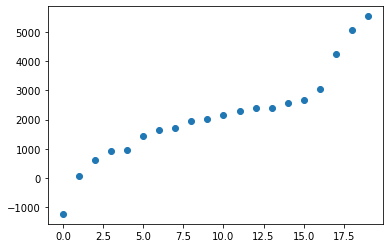

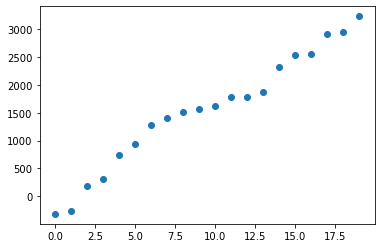

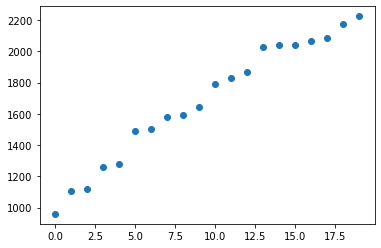

1681.0


In [16]:
import matplotlib.pyplot as plt

epsilon = 1.

test_dates = all_dates[:128].copy()
test_counts = all_counts[:128].copy()

number_of_queries = 20
range_dates = ('2014-01-02','2014-01-9')
answears128 = np.zeros(number_of_queries)
corret_answear = np.sum(all_counts[0:8])

for i in range(0,number_of_queries):
    FLAT_OLH = OLH_flat(epsilon, test_dates, test_counts)
    a = FLAT_OLH.answer(range_dates)
    answears128[i] = a

x = np.arange(0,number_of_queries)
answears128.sort()
plt.scatter(x,answears128)
plt.show()

test_dates = all_dates[:64].copy()
test_counts = all_counts[:64].copy()
number_of_queries = 20

range_dates = ('2014-01-02','2014-01-9')
answears_64 = np.zeros(number_of_queries)

for i in range(0,number_of_queries):
    FLAT_OLH = OLH_flat(epsilon, test_dates, test_counts)
    a = FLAT_OLH.answer(range_dates)
    answears_64[i] = a
 
x = np.arange(0,number_of_queries)
answears_64.sort()
plt.scatter(x,answears_64)
plt.show()

test_dates = all_dates[:32].copy()
test_counts = all_counts[:32].copy()
number_of_queries = 20

range_dates = ('2014-01-02','2014-01-9')
answears_32 = np.zeros(number_of_queries)

for i in range(0,number_of_queries):
    FLAT_OLH = OLH_flat(epsilon, test_dates, test_counts)
    a = FLAT_OLH.answer(range_dates)
    answears_32[i] = a

x = np.arange(0,number_of_queries)
answears_32.sort()
plt.scatter(x,answears_32)
plt.show()
print(corret_answear)

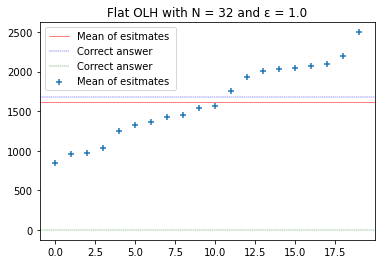

In [13]:
def plot_estimates_flat(number_of_qurries, N, model, epsilon, dates, counts, range_qurey, plot_name):
    
    test_dates, test_counts = dates[:N].copy(), counts[:N].copy()
    answers = np.zeros(number_of_queries)
    

    for i in range(0,number_of_queries):
        current_model = model(epsilon, test_dates, test_counts)
        answer = current_model.answer(range_qurey)
        answers[i] = answer
    #print(answers)
    correct_answer = current_model.real_answer(range_qurey)
    
    x = np.arange(0,number_of_queries)
    answers.sort()

    plt.scatter(x,answers, marker = '+', label="Mean of esitmates")
    plt.axhline(np.mean(answers),linewidth=0.5, color='r', linestyle = '-', label="Mean of esitmates ")
    plt.axhline(correct_answer,linewidth=.4, color='b', linestyle = '--', label="Correct answer")
    plt.axhline(current_model.var,linewidth=.4, color='g', linestyle = '--', label="Correct answer")
    #plt.hlines(np.mean(answears128),line_range[0],line_range[1])
    #plt.hlines(np.mean(correct_answear),line_range[0],line_range[1])
    plt.legend()
    plt.title(f'Flat OLH with N = {N} and \u03B5 = {epsilon}')
    plt.savefig(plot_name,dpi=300,bbox_inches='tight')
    plt.show()
    
    return answers
    
    
range_dates = ('2014-01-02','2014-01-9')    
epsilon = 1.
number_of_qurries = 50 
N = 32
a = plot_estimates_flat(number_of_qurries, N, OLH_flat, epsilon, all_dates, all_counts, range_dates, '123.png')


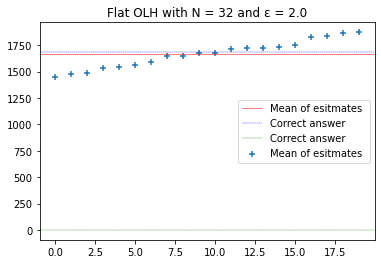

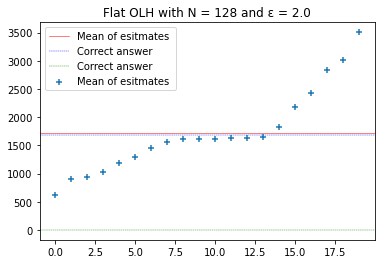

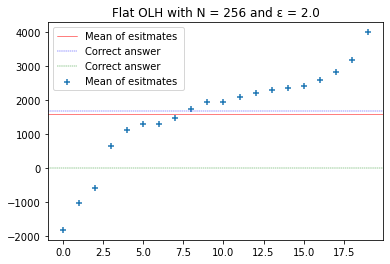

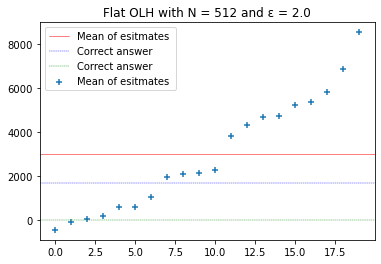

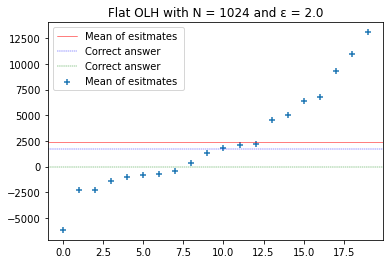

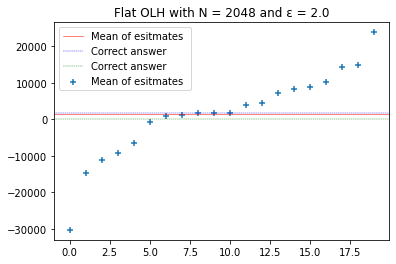

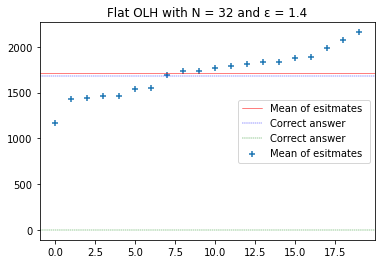

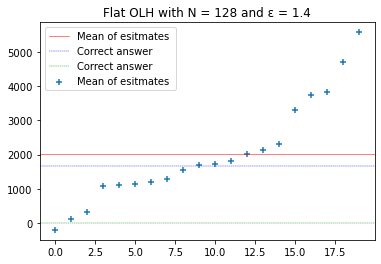

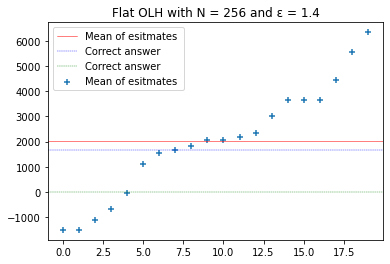

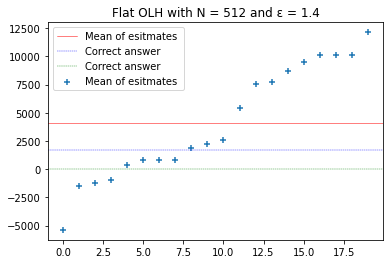

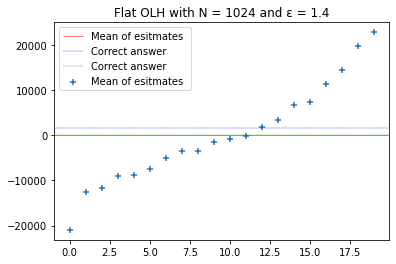

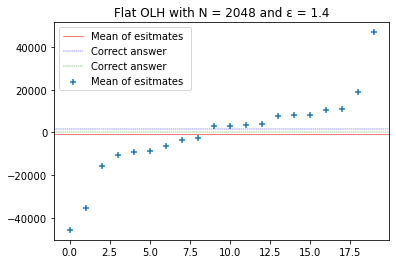

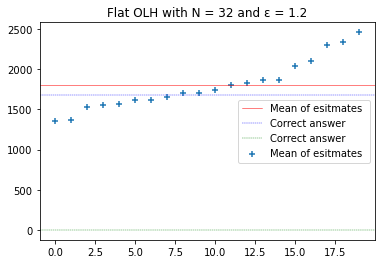

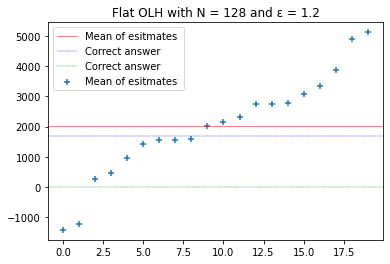

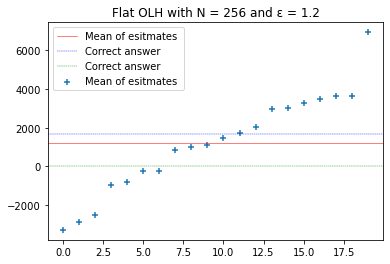

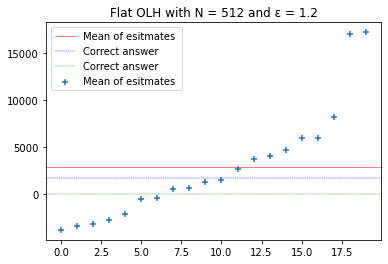

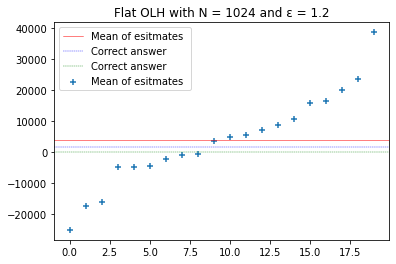

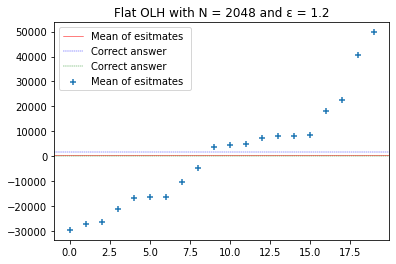

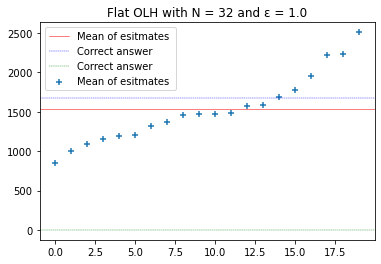

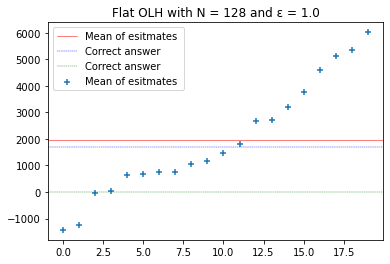

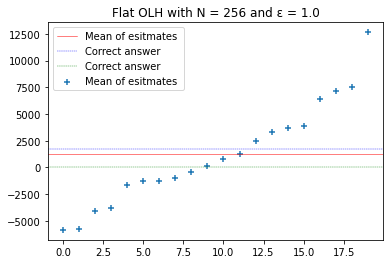

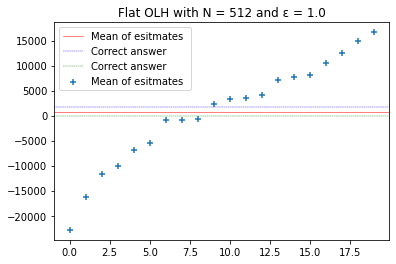

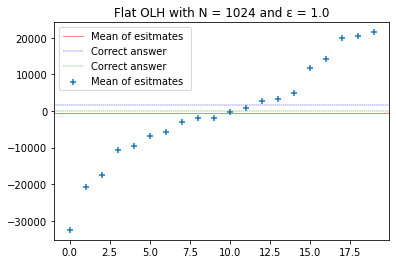

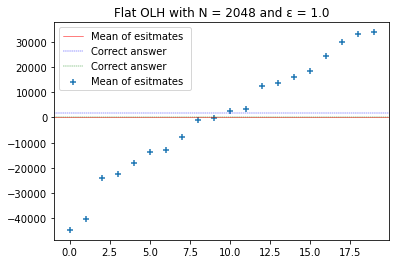

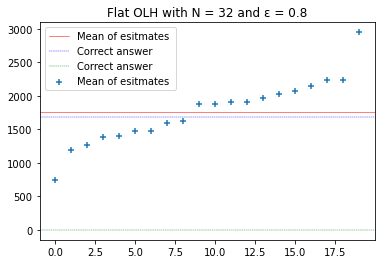

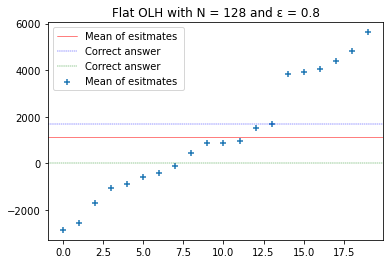

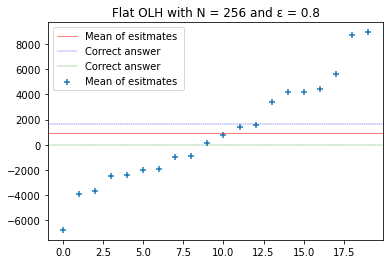

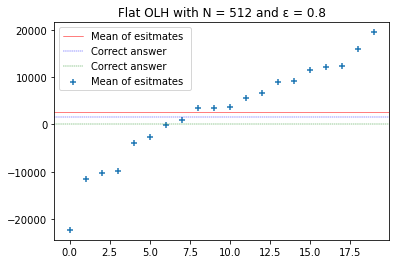

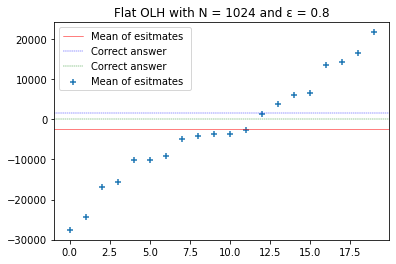

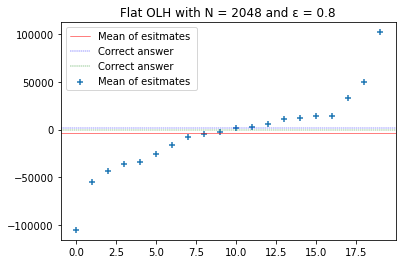

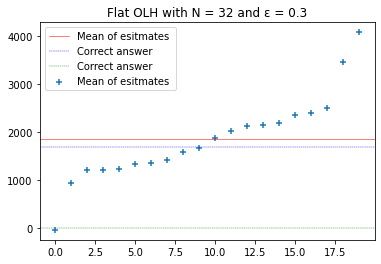

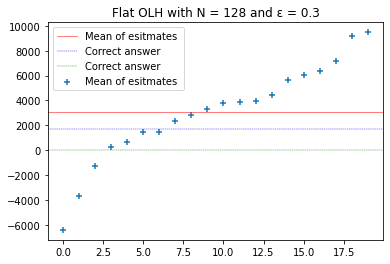

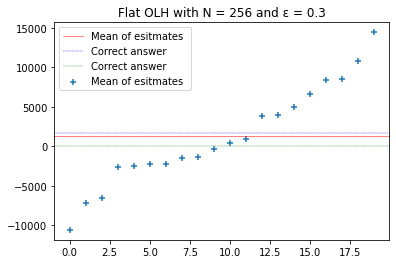

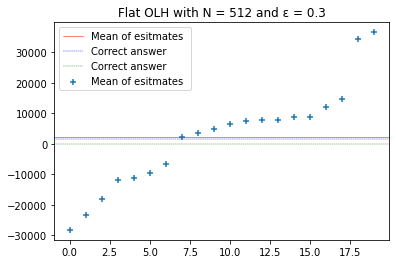

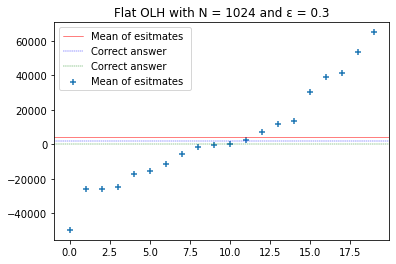

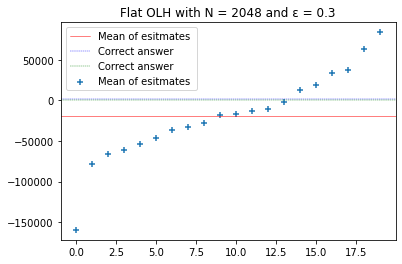

In [18]:
epsilons = np.array([2,1.4,1.2,1,0.8,0.3])
n = np.array([32,128,256,512,1024,2048])
number_of_qurries = 20
range_dates = ('2014-01-02','2014-01-9')   

for e in epsilons:
    for N in n:
        plot_name = 'plots/local_flat_freq/' + f'flat_freq_e={e}_N={N}.png'
        csv_name = 'results/local_flat_freq/' + f'flat_freq_e={e}_N={N}.csv'
        answers = plot_estimates_flat(number_of_qurries, N, OLH_flat, e, all_dates, all_counts, range_dates, plot_name)
        np.savetxt(csv_name, answers, delimiter=',')

In [ ]:
epsilons = np.array([2,1.4,1.2,1,0.8,0.7,0.5,0.4,0.3])
error_dicts = {}
test_dates = all_dates[:128].copy()
test_counts = all_counts[:128].copy()
for e in epsilons:
    print(e)
    number_of_queries = 100
    range_dates = ('2014-01-02','2014-01-9')
    answears = np.zeros(number_of_queries)
    corret_answear = np.sum(all_counts[0:8])
    for i in range(0,number_of_queries):
        FLAT_OLH = OLH_flat(e, test_dates, test_counts)
        a = FLAT_OLH.answer(range_dates)
        answears[i] = a
    error = np.abs(corret_answear-answears)
    max_error = np.amax(error)
    min_error = np.amin(error)
    true_values = np.full(number_of_queries, corret_answear)
    #vfunc = np.vectorize(relative_error)
    #rel_erorrs = vfunc(answears, corret_answear)
    mse = mean_squared_error(true_values, answears)
    error_dicts[e] = {'mse': mse, 'max': max_error, 'min': min_error, 'abs': np.mean(error)}



In [ ]:
#Getting all error values from dict
n = len(error_dicts)
mse_errors = np.zeros(n)
min_errors = np.zeros(n)
max_errors = np.zeros(n)
abs_errors = np.zeros(n)

for num, item in enumerate(error_dicts.items()):
    mse_errors[num] = item[1]['mse']
    min_errors[num] = item[1]['min']
    max_errors[num] = item[1]['max']
    abs_errors[num] = item[1]['abs']
    
error_stack = np.vstack((min_errors,mse_errors,max_errors,abs_errors)).flatten()
min_labels = np.full(min_errors.size, 'min errors')
mse_labels = np.full(mse_errors.size, 'mse errors')
max_labels = np.full(max_errors.size, 'max errors')
abs_labels = np.full(abs_errors.size, 'abs errors')


labels_stack = np.vstack((min_labels,mse_labels,max_labels,abs_labels)).flatten()
epsilons_stack = np.vstack((epsilons,epsilons,epsilons,epsilons)).flatten()

seaborn_df = pd.DataFrame({'epsilons':epsilons_stack, 'errors':error_stack,'labels':labels_stack})
seaborn_df.to_csv('flat_freq_olh_seaborn_plotting_data.csv',index=False)

all_data = pd.DataFrame({'epsilons':epsilons, 'min_errors':min_errors,'max_errors':min_errors,'mse_errors':mse_errors,'abs_errors':abs_errors})
all_data.to_csv('flat_freq_plotting_data.csv',index=False)
sns.set()
sns_plot = sns.catplot(x="epsilons", y="errors", hue="labels", data=seaborn_df)
sns_plot.set(yscale="log")
sns_plot.savefig("flat_freq_AllErrors.png")

In [ ]:
class OUE:
    def __init__(self, epsilon):
        # We need the stream to be a power of 2
        self.epsilon = epsilon
        
    
    def process(self, e_i):
        o_i = e_i.copy()
        for idx, j in enumerate(e_i):
            if i == 1:
                o_i[idx] = np.random.randint(2)
            else:
                if np.random.uniform(0,1) < 1/(1+np.exp(epsilon)):
                    o_i[idx] = 1
                else:
                    o_i[idx] = 0
                    
    def aggreation(self, day, lst):
        return ( ( lst[:,day] +len(lst)/(1+np.exp(epsilon))) * (1/2 -1/(1+np.exp(epsilon))))
        
                

In [ ]:
len(all_dates)
print(all_dates[0]-all_dates[-1])

In [ ]:
oue_count_lock = threading.Lock()
oue_count_lock.acquire()
oue_count_lock.release()

In [ ]:
#len(oue_count)

In [ ]:
def OUE_func_2(e_i, epsilon):
    #print('Call')
    #print(e_i)
    if e_i == 1:
        #print('if')
        return np.random.randint(2)
    else:
        #print('else')
        if np.random.uniform(0,1) < 1/(1+np.exp(epsilon)):
            return 1
        else:
            return 0

In [ ]:
def OUE_answear(data, i, epsilon):
    return (data[i]/len(data) + len(data)/(1+np.exp(epsilon))) / (1/2 -1/(1+np.exp(epsilon)))

In [ ]:
D = len(all_dates) 
oue_count = np.zeros(D)

In [ ]:

vfunc = np.vectorize(OUE_func_2, otypes = [int])
epsilon = 1
vfunc([0,1,1,1,1], epsilon)
for idx, count in enumerate(all_counts):
    #print(idx)
    #print(count)
    for i in range(0,int(count)):
        sparse = np.zeros(D)
        sparse[idx] = 1
        dense = vfunc(sparse,epsilon)
        oue_count = oue_count + dense

In [ ]:
print(idx)
print(count)
print(i)

In [ ]:
print(oue_count)

In [ ]:
#np.savetxt('oue_count.csv', oue_count, delimiter=',')

In [ ]:
print(( oue_count[0] +len(oue_count)/(1+np.exp(epsilon))) * (1/2 -1/(1+np.exp(epsilon))))

In [ ]:
vfunc = np.vectorize(OUE_func_2, otypes = [int])
vfunc([0,1,1,1,1], 0.2)

In [ ]:
epsilon = 1
np.exp(epsilon)+1

In [ ]:
def OUE_func(e_i, epsilon):
    o_i = e_i.copy()
    for idx, j in enumerate(e_i):
        if j == 1:
            o_i[idx] = np.random.randint(2)
        else:
            if np.random.uniform(0,1) < 1/(1+np.exp(epsilon)):
                o_i[idx] = 1
            else:
                o_i[idx] = 0
    return o_i

In [ ]:
class flat_OUE:
    def __init__(self, epsilon, dates, counts):
        
        self.dates = dates
        self.real_counts = counts
        self.epsilon = epsilon
        self.counts = self.process(dates, counts)
        self.D = len(dates)
        
        values = np.arange(0,len(self.dates))
        zip_iterator = zip(self.dates, values)
        self.idx_dict =  dict(zip_iterator)
    
    def process(self, dates, counts):        
        vfunc = np.vectorize(OUE_func_2, otypes = [int])
        for idx, count in enumerate(all_counts):
            for i in range(0,int(count)):
                sparse = np.zeros(D)
                sparse[idx] = 1
                dense = vfunc(sparse,self.epsilon)
                oue_count = oue_count + dense
        return oue_count
    
    def answer(self, dates):
        
        if (len(dates) < 2):
                date_obj_0 = datetime.strptime(dates[0],'%Y-%m-%d').date()
                #print(date_obj_0)
                #print(type(date_obj_0))
                idx = self.idx_dict[date_obj_0]
                return self.noise_counts[idx]
            
        else:
            date_obj_0 = datetime.strptime(dates[0],'%Y-%m-%d').date()
            date_obj_1 = datetime.strptime(dates[1],'%Y-%m-%d').date()
            idx_0 = self.idx_dict[date_obj_0]
            idx_1 = self.idx_dict[date_obj_1]

                #idx_0 is not 0
            if idx_0:
                return self.noise_counts[idx_1] - self.noise_counts[idx_0-1]            
            else:
                return self.noise_counts[idx_1]

In [ ]:
def OLH_func(x, epsilon, g):
    if np.random.uniform(0,1) < np.exp(epsilon)/(np.exp(epsilon)+g-1):
        #print('if')
        return x
    else:
        return np.random.randint(low = 0, high = g)
    
def OLH_answer(data, j, epsilon, N, g):
    p = np.exp(epsilon)/(np.exp(epsilon)+g-1)
    #print(p - 1/g)
    return (data[j]- N/g) / (p)

In [ ]:
epsilon = 0.7
g = 2005
print(np.exp(epsilon)/(np.exp(epsilon)+g+1))

In [ ]:
D = len(all_dates) 
OLH_count = np.zeros(D)

In [ ]:
epsilon = 1
for idx, count in enumerate(all_counts):
    for i in range(0,int(count)):
        response = OLH_func(idx, epsilon, D)
        OLH_count[response] = OLH_count[response] + 1

In [ ]:
#print(OLH_count)
#print(np.sum(OLH_count))
print(all_counts[1174])
print(OLH_answer(OLH_count, 1174, epsilon, np.sum(OLH_count), D))
#N = np.sum(all_counts)
N = len(all_counts)
print(f'var should be {4*np.exp(epsilon) / (N*np.exp(epsilon) - N)**2}')

In [ ]:
epsilons = np.array([2,1.4,1.2,1,0.8,0.7,0.5,0.4,0.3])
error_dicts = {}
test_dates = all_dates[:32].copy()
test_counts = all_counts[:32].copy()
for e in epsilons:
    print(e)
    number_of_queries = 100
    range_dates = ('2014-01-02','2014-01-9')
    answears = np.zeros(number_of_queries)
    corret_answear = np.sum(all_counts[0:8])
    for i in range(0,number_of_queries):
        hhs = hhs = HH_OLH(test_dates, test_counts,OLH_func,e)
        a = hh_olh_answer(hhs, range_dates, HH_OLH_answer, test_dates, test_counts, e)
        answears[i] = a
    error = np.abs(corret_answear-answears)
    max_error = np.amax(error)
    min_error = np.amin(error)
    true_values = np.full(number_of_queries, corret_answear)
    #vfunc = np.vectorize(relative_error)
    #rel_erorrs = vfunc(answears, corret_answear)
    mse = mean_squared_error(true_values, answears)
    error_dicts[e] = {'mse': mse, 'max': max_error, 'min': min_error, 'abs': np.mean(error)}



In [ ]:
#Getting all error values from dict
n = len(error_dicts)
mse_errors = np.zeros(n)
min_errors = np.zeros(n)
max_errors = np.zeros(n)
abs_errors = np.zeros(n)

for num, item in enumerate(error_dicts.items()):
    mse_errors[num] = item[1]['mse']
    min_errors[num] = item[1]['min']
    max_errors[num] = item[1]['max']
    abs_errors[num] = item[1]['abs']

In [ ]:
error_stack = np.vstack((min_errors,mse_errors,max_errors,abs_errors)).flatten()
min_labels = np.full(min_errors.size, 'min errors')
mse_labels = np.full(mse_errors.size, 'mse errors')
max_labels = np.full(max_errors.size, 'max errors')
abs_labels = np.full(abs_errors.size, 'abs errors')


labels_stack = np.vstack((min_labels,mse_labels,max_labels,abs_labels)).flatten()
epsilons_stack = np.vstack((epsilons,epsilons,epsilons,epsilons)).flatten()


In [ ]:
seaborn_df = pd.DataFrame({'epsilons':epsilons_stack, 'errors':error_stack,'labels':labels_stack})
seaborn_df.to_csv('local_hh_seaborn_plotting_data.csv',index=False)

In [ ]:
all_data = pd.DataFrame({'epsilons':epsilons, 'min_errors':min_errors,'max_errors':min_errors,'mse_errors':mse_errors,'abs_errors':abs_errors})
all_data.to_csv('local_hh_plotting_data.csv',index=False)

In [ ]:
sns.set()

In [ ]:
sns_plot = sns.catplot(x="epsilons", y="errors", hue="labels", data=seaborn_df)
sns_plot.set(yscale="log")
sns_plot.savefig("local_hh_AllErrors.png")


In [ ]:
sns_plot = sns.scatterplot(data=seaborn_df.loc[seaborn_df['labels'] == 'min errors'], x ='epsilons', y ='errors')
plt.legend(labels=['min errors'])
sns_plot.get_figure().savefig('con_min_error.png') 